In [1]:
import sys
sys.path.append('../../../src')
from common import common, transform, json
from common.functions import normalize_vector, cos_similarity, gauss
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.heatmap import Heatmap
from display.display import display
from display.video import Video
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Indivisual Activity をロード

In [2]:
room_num = '09'
date = '20210304'
name = 'gaze1-3'

In [3]:
individual_activity_json = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name))
field_path = os.path.join(common.data_dir, '{}/field0304.png'.format(room_num))

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num + '_0304'][0]
p_field = common.homo[room_num + '_0304'][1]
homo = transform.Homography(p_video, p_field, field_raw.shape)

In [5]:
individual_activity_data = json.load(individual_activity_json)

In [6]:
from common.json import IA_FORMAT
from individual_activity.individual_activity import IndividualActivity

def make_individuals(datas, homo):
    individuals = {}
    for data in datas:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        for key in IA_FORMAT[3:]:
            ia.indicator_dict[key][frame_num] = data[key]
            
    return list(individuals.values())

In [7]:
individuals = make_individuals(individual_activity_data, homo)

# コサイン類似度の平均から求める

In [8]:
def calc_likelihood(frame_num, individuals, obj_point):
    results = []
    for individual in individuals:
        position = individual.get_data('position', frame_num)
        face = individual.get_data('face_vector', frame_num)
        if position is None or face is None:
            continue

        pos2obj = obj_point - position
        pos2obj = normalize_vector(pos2obj.astype(float))
        cos = cos_similarity(face, pos2obj)
        likelihood = gauss(cos, mu=1, sigma=(1 - np.cos(np.deg2rad(10))))
        results.append(likelihood)
        
    return np.average(results) 

# 検証

In [9]:
# out video file path
out_path = common.data_dir + '{}/{}/{}/out/{}_result.mp4'.format(room_num, date, name, 'attention')

In [10]:
max_frame_num = max([max(individual.tracking_points.keys()) for individual in individuals])

fig_shape = field_raw.shape[1::-1]
results = []
for frame_num in tqdm(range(max_frame_num + 1)):
    for x in range(0, fig_shape[0], 20):
        for y in range(0, fig_shape[1], 20):
            likelihood = calc_likelihood(frame_num, individuals, np.array([x, y]))
            results.append({
                'frame': frame_num,
                'point': (x, y),
                'likelihood': likelihood
            })

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:30<00:00,  6.36it/s]


In [51]:
VECTOR_SETTING_LIST = {
    # arrow_length, color, tip_length
    IA_FORMAT[4]: [40, (255, 0, 0), 1.0],   # face vector
    IA_FORMAT[5]: [60, (0, 0, 255), 1.5],   # body vector
}


def disp_body_face(frame_num, individuals, field):
    def disp_arrow(key, data, field):
        position = data.get_data(IA_FORMAT[3], frame_num)
        vector = data.get_data(key, frame_num)
        arrow_length = VECTOR_SETTING_LIST[key][0]

        if position is not None and vector is not None:
            # 矢印の先端の座標を計算
            end = (np.array(position) +
                   (np.array(vector) * arrow_length)).astype(int)

            color = VECTOR_SETTING_LIST[key][1]
            tip_length = VECTOR_SETTING_LIST[key][2]
            cv2.arrowedLine(
                field,
                tuple(position),
                tuple(end),
                color,
                tipLength=tip_length,
                thickness=2)

        return field

    for data in individuals:
        # face vector
        field = disp_arrow(IA_FORMAT[4], data, field)
        # body vector
        field = disp_arrow(IA_FORMAT[5], data, field)

    return field


# heatmap
th = 0.3
heatmap = Heatmap([th, 1])

def plot_likelihood(results, field):
    for result in results:
        point = result['point']
        likelihood = result['likelihood']
        if likelihood >= th:
            color = heatmap.colormap(likelihood)
            cv2.circle(field, point, 5, tuple(color), thickness=-1)
        
    return field
    
    
def combine_image(frame, field):
    ratio = 1 - (field.shape[0] - frame.shape[0]) / field.shape[0]
    size = [int(field.shape[1] * ratio), int(field.shape[0] * ratio)]
    if frame.shape[0] != size[1]:
        # 丸め誤差が起きる
        size[1] = frame.shape[0]
    field = cv2.resize(field, size)
    frame = np.concatenate([frame, field], axis=1)
    return frame

In [52]:
# load video
video_path = os.path.join(common.data_dir, '{0}/{1}/{2}/video/AlphaPose_{2}.mp4'.format(room_num, date, name))
video = Video(video_path)

frames = []
for frame_num in tqdm(range(video.frame_num)):
    # read frame
    frame_raw = video.read()
    
    field = disp_body_face(frame_num, individuals, field_raw.copy())
    
    results_frame = [result for result in results if result['frame'] == frame_num]
    field = plot_likelihood(results_frame, field)
    
    # append tracking result
    img = combine_image(frame_raw, field)
    frames.append(img)
    
print('writing videos into {} ...'.format(out_path))
video.write(frames, out_path, frames[0].shape[1::-1])

100%|██████████| 576/576 [00:38<00:00, 14.92it/s]


writing videos into /Users/koji/program/research/data/09/20210304/gaze1-3/out/attention_result.mp4 ...


# 特徴量を抽出

In [14]:
manual_results = {
    'gaze1-1': {'frame': 413, 'order': [0, 2, 1]},
    'gaze1-2': {'frame': 330, 'order': [0, 1, 2]},
    'gaze1-3': {'frame': 324, 'order': [0, 1, 2]},
    'gaze2-1': {'frame': 302, 'order': [0, 1, 2]},
    'gaze2-2': {'frame': 318, 'order': [0, 1, 2]},
    'gaze2-3': {'frame': 309, 'order': [0, 1, 2]},
    'gaze3-1': {'frame': 347, 'order': [0, 1, 2]},
    'gaze3-2': {'frame': 318, 'order': [0, 1, 2]},
    'gaze3-3': {'frame': 338, 'order': [0, 1, 2]},
}

In [15]:
from common.object_point import EX0304 as object_points
from common.functions import normalize_vector, cos_similarity

def extract_features(individuals, name):
    manual_result = manual_results[name]
    
    max_frame_num = max([max(individual.tracking_points.keys()) for individual in individuals])
    
    features_1st = []
    features_2nd = []
    for frame_num in range(max_frame_num):
        for i, individual in enumerate(individuals):
            position = individual.get_data('position', frame_num)
            face = individual.get_data('face_vector', frame_num)
            if position is None or face is None:
                continue
            results = {}
            for label, obj in object_points.items():
                pos2obj = np.array(obj) - position
                pos2obj = normalize_vector(pos2obj.astype(float))
                results[label] = cos_similarity(face, pos2obj)
            
            if frame_num < manual_result['frame']:
                features_1st.append(results)
            else:
                features_2nd.append(results)
                
    features_1st = pd.DataFrame.from_dict(features_1st)
    features_2nd = pd.DataFrame.from_dict(features_2nd)
    return features_1st, features_2nd


def extract_features(individuals, name):
    manual_result = manual_results[name]
    
    max_frame_num = max([max(individual.tracking_points.keys()) for individual in individuals])
    
    features_1st = []
    features_2nd = []
    for pre_frame_num in range(0, max_frame_num - 1):
        frame_num = pre_frame_num + 1
        results = {}
        for i in range(len(individuals)):
            for j in range(len(individuals)):
                if i == j:
                    continue
                p1 = individuals[i]
                p2 = individuals[j]
                
                pre_face = p1.get_data('face_vector', pre_frame_num)
                face = p1.get_data('face_vector', frame_num)
                face2 = p2.get_data('face_vector', frame_num)
                if pre_face is None or face is None or face2 is None:
                    continue

                results[i + 1] = np.arctan2(face2[1], face2[0]) - np.arctan2(face[1], face[0])

                if frame_num < manual_result['frame']:
                    features_1st.append(results)
                else:
                    features_2nd.append(results)
                
    features_1st = pd.DataFrame.from_dict(features_1st)
    features_2nd = pd.DataFrame.from_dict(features_2nd)
    return features_1st, features_2nd

In [16]:
features_1st = []
features_2nd = []
for i, individuals in enumerate(individuals_lst):
    f1, f2 = extract_features(individuals, 'gaze1-' + str(i + 1))
    features_1st.append(f1)
    features_2nd.append(f2)

gaze1-1


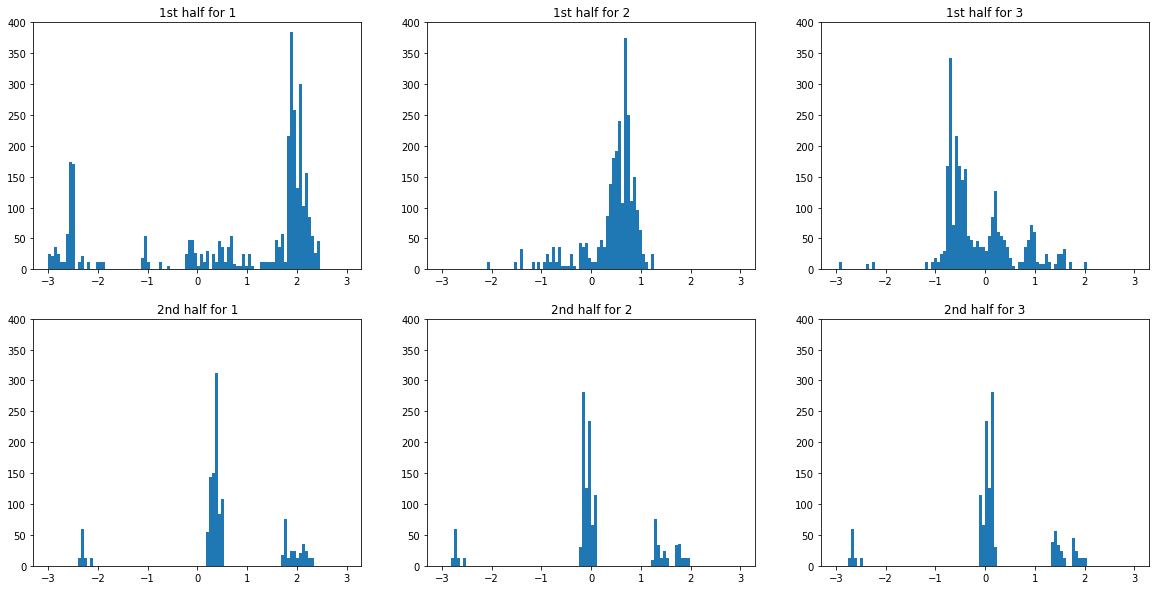

gaze1-2


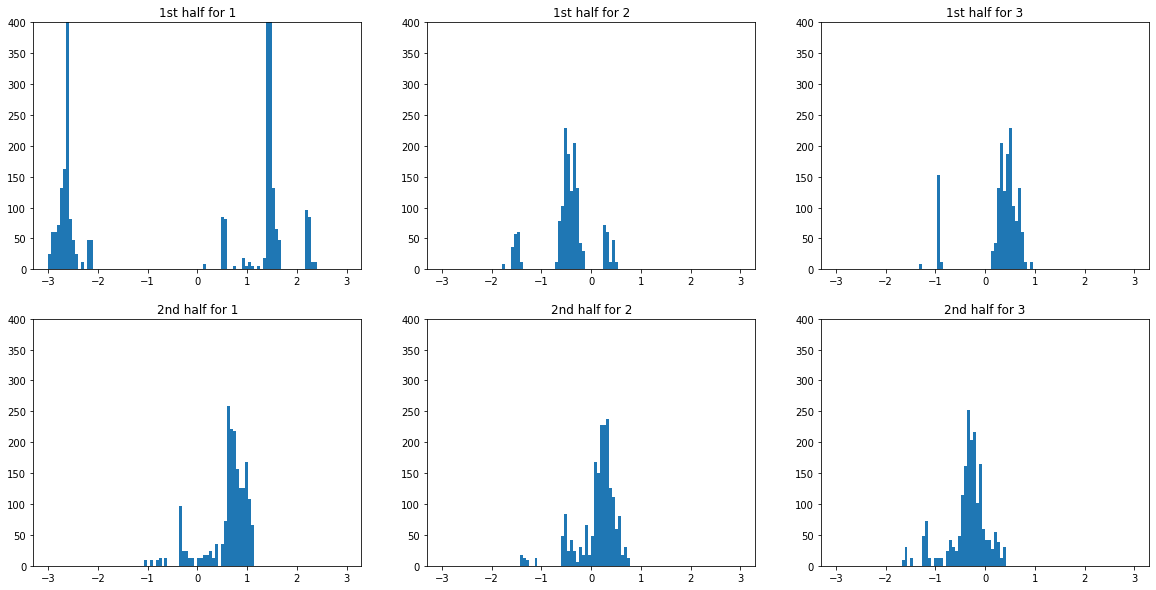

gaze1-3


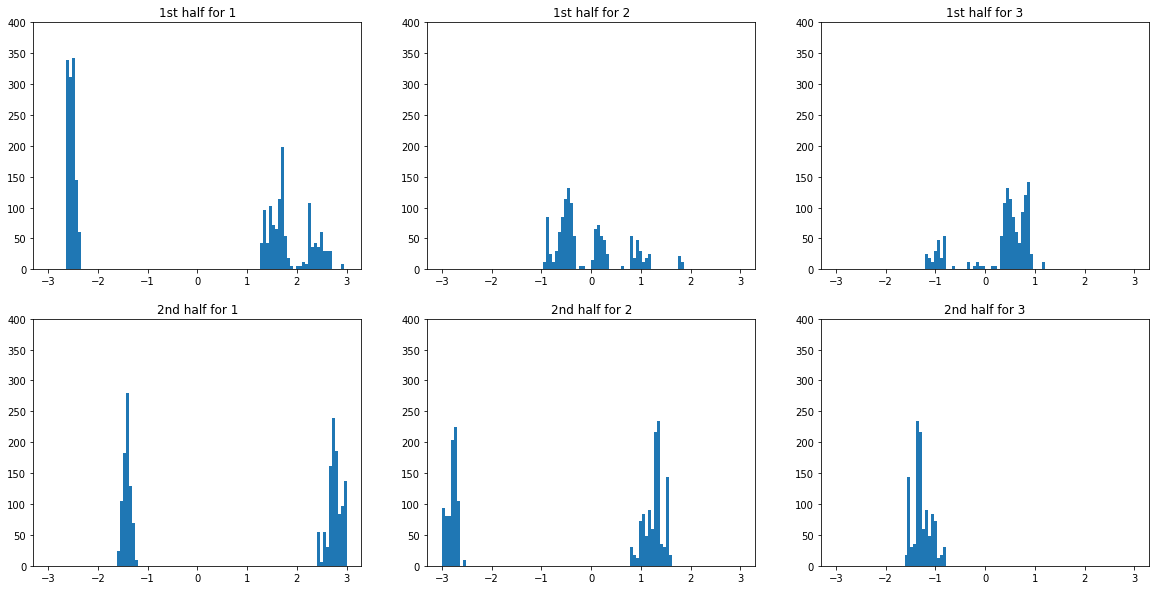

In [17]:
for i in range(3):
    print('gaze1-%d' % (i + 1))
    
    f1 = features_1st[i]
    f2 = features_2nd[i]
    
    fig = plt.figure(figsize=(20, 10))
    key_num = len(object_points.keys())
    bins=100
    vmax=400
    for label in object_points.keys():
        ax = fig.add_subplot(2, key_num, label)
#         ax.hist(f1[label], range=(-1, 1), bins=bins)
        ax.hist(f1[label], range=(-3, 3), bins=bins)
        ax.set_ylim((0, vmax))
        ax.set_title('1st half for %d' % label)
        
        ax = fig.add_subplot(2, key_num, label + key_num)
#         ax.hist(f2[label], range=(-1, 1), bins=bins)
        ax.hist(f2[label], range=(-3, 3), bins=bins)
        ax.set_ylim((0, vmax))
        ax.set_title('2nd half for %d' % label)
        
    plt.show()